
# All the supercool libraries we used

In [ ]:
import gym
import random
import numpy as np
from keras.layers import Input, Conv2D, Dense, MaxPooling2D , Flatten
from keras.models import Model, Sequential, load_model
from collections import deque
from keras.optimizers import Adam
import keras
import matplotlib.pyplot as plt

# Approach

We consider the task of learning to play Space Invaders, a popular Atari console game. Formally, an agent interacts with an *environment* in a sequence of *actions*, *observations* and *rewards*.<br> We use the Atari emulator open sourced by OpenAI (Brockman et al. 2016), the OpenAI gym. This emulator provides an environment represents each state by a raw RGB image of the screen which has a size (210,160,3) (SpaceInvaders-v0) 

In [ ]:
env = gym.make('SpaceInvaders-v0')

When working directly with raw pixels, the image frames are 210x160, with a 128 color palette. In order to avoid the huge dimension of data that are useless for our task, we preprocess the image frames from the emulator to convert them to grayscale images, downsample them to reduce the number of pixels and crop them to a size of 90x80 pixels 

In [ ]:
def to_greyscale(img):
        return np.mean(img , axis=2).astype(np.uint8)
def downsample(img):
        return img[::2 , ::2]
def crop(img):
    return img[10:100 ,:]
def preprocess(img):
        return crop(to_greyscale(downsample(img)))/255

# Enjoy the result!

In [ ]:
img = env.reset()
plt.imshow(preprocess(img))

The game play is discretized into time-steps and at each time step, the agent chooses an action a from the set of possible actions for each state A = {1,2,...L}. The emulator applies the action to the current state, and brings the game to a new state. The game score is updated and  the reward r is returned to the agent. We formalize this problem as follows: 

1. State **s**: A sequence of observations, where an observation is a matrix representing the image frame 
2. Action **a** : An integer in the range of [1,L]. In case of Space Invaders L = 6 and the actions are {FIRE(shoot without moving), RIGHT (move right),  LEFT (move left), RIGHTFIRE (shoot and move right), LEFTFIRE (shoot and move left),NOOP (no operation)}
3. Reward **r**: Reward returned by the environment

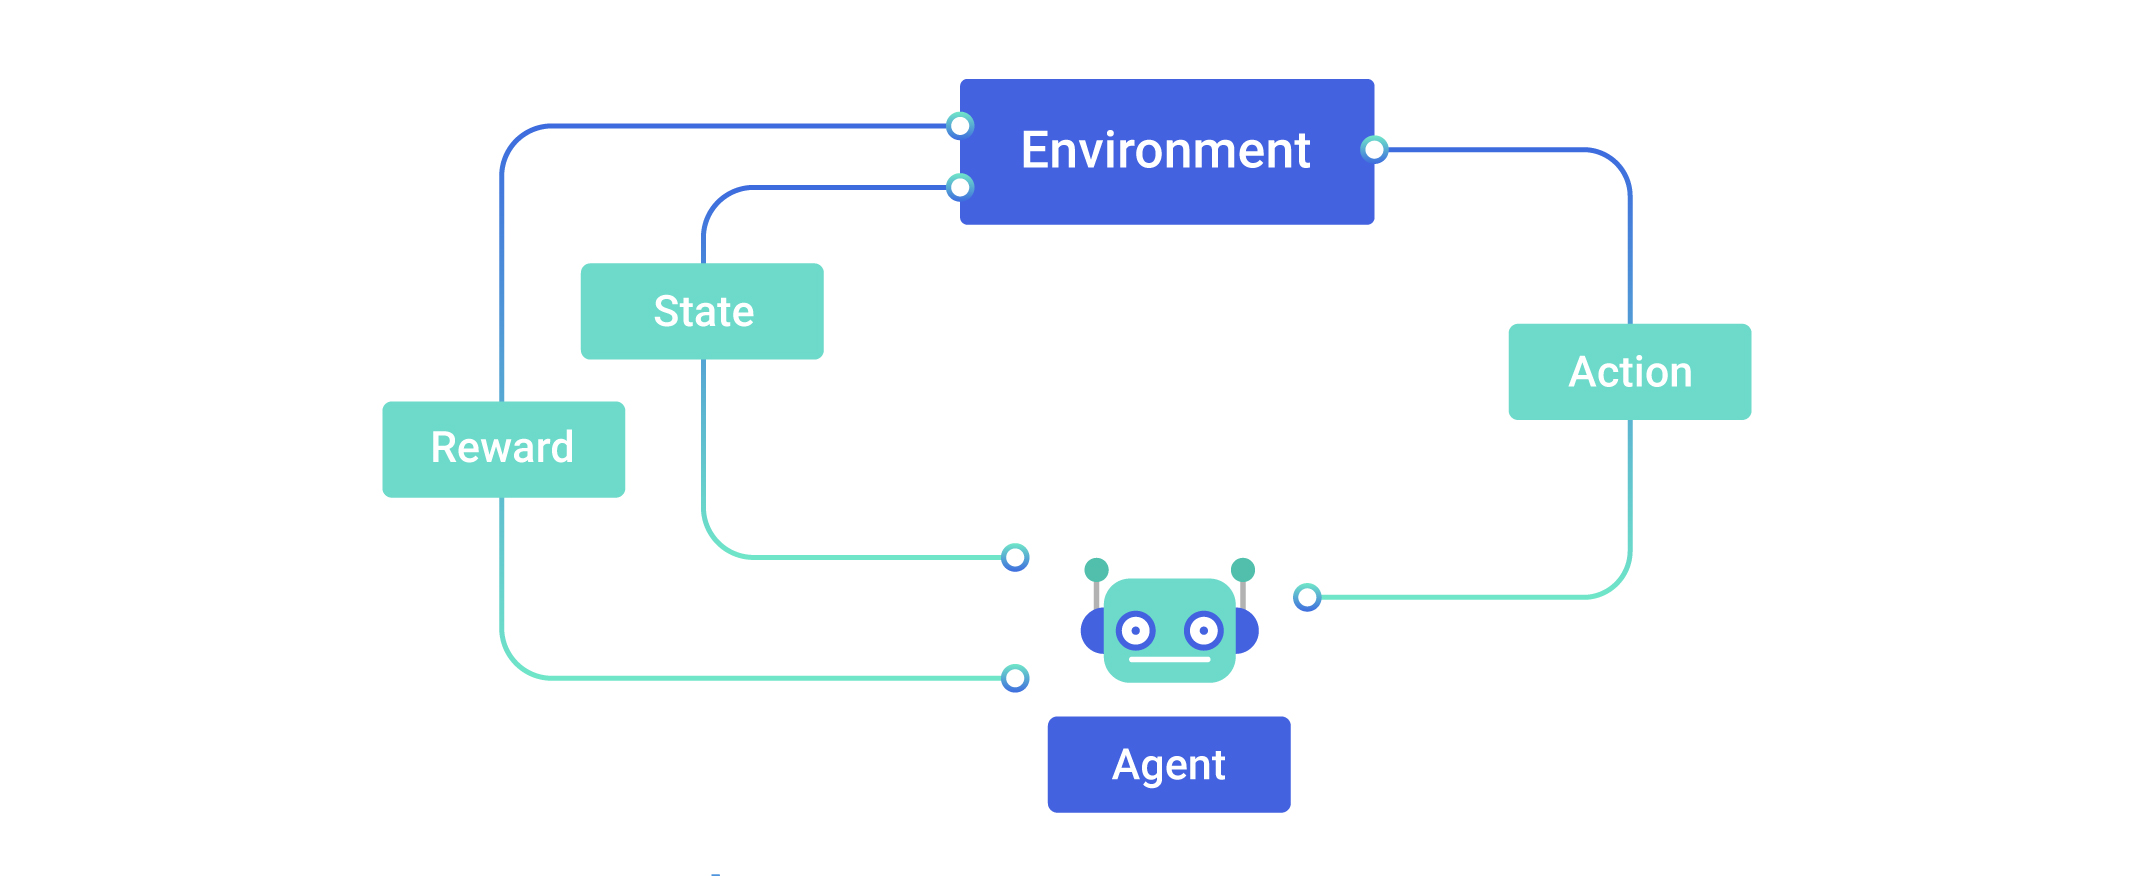

Given a sequence of state, actions, rewards  s1,a1,r1,s2,a2,r2.., we want to learn the optimal strategy to play the game. The goal of the agent is to learn a strategy to maximize future rewards.
We assume that the rewards are discounted by a factor of γ at every time step and deﬁne the future discounted return RT as the sum of γrt. We also deﬁne the optimal action value function Qopt(s,a) to be the reward we get following the optimal policy and starting in state s and playing action a.
Given a Markov Decision Process with transition probabilities p(s,a,s') and rewards r(s,a), the Q-function satisﬁes a recurrence known as the Bellman equation.

$\underbrace{\text{New}Q(s,a)}_{\scriptstyle\text{New Q-Value}}=Q(s,a)+\mkern-34mu\underset{\text{Learning rate}}{\underset{\Bigl|}{\alpha}}\mkern-30mu[\underbrace{R(s,a)}_{\scriptstyle\text{Reward}}+\mkern-30mu\underset{\text{Discount rate}}{\underset{\Biggl|}{\gamma}}\mkern-75mu\overbrace{\max Q'(s',a')}^{\scriptstyle\substack{\text{Maximum predicted reward, given} \\ \text{new state and all possible actions}}}\mkern-45mu-Q(s,a)]$

However in the setting of reinforcement learning, we do not know the transition probabilities and rewards for each transition.Also we can’t obtain the actual optimal q-value function because of the function approximation, so we obtain a suboptimal one using a neural network.

We have very high dimensional data such as an image and it is hard to extract features. To handle high dimensional inputs where the agent learns from raw inputs such as image frames, Mnih et al. 2013 introduced Deep Q-Networks which uses a convolutional neural network to approximate the Q-function. 
Our convolutional neural network is a sequential model composed by 3 convolutional layers, two of them with 16 filters and the last one with 32 filters. The dqn has also two dense layers: the first one with 128 units, and the last one with 6 units that give as output the q-values, one for each action.
The objective is to now learn the weights θi Q-network.
We try to learn the optimal strategy by minimizing the squared loss function using the ADAM optimizer (instead of stochastic gradient descendence)


In [ ]:
class DQN:
    def __init__(self, input_shape, output_shape, discount=0.99, update_target_every=10, memory_size=2000):
        self.input_shape=input_shape
        self.output_shape=output_shape
        self.discount=discount
        self.update_target_every=update_target_every
        self.policy_net=self.create_model()
        self.memory=deque(maxlen=memory_size)
        self.target_counter=0 
    
    def create_model(self):
        model=Sequential()
        model.add(Conv2D(input_shape=self.input_shape, filters=16, kernel_size=(8,8), strides=(4,4), padding="valid", 
                        activation="relu", use_bias=True,))
        model.add(Conv2D(filters=16, kernel_size=(4,4), strides=(2,2), padding="valid", 
                       activation="relu", use_bias=True,))
        #model.add(Conv2D(filters=32, kernel_size=(2,2), padding="valid", 
        #                activation="relu", use_bias=True,))
        model.add(Flatten())
        model.add(Dense(128, activation="relu"))
        model.add(Dense(self.output_shape))
        adm=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
        model.compile(loss="mse", optimizer=adm, metrics=["accuracy"] )
        return model        

A technique called experience replay is used in Deep Q learning to help with convergence. At every time step we store the agents observations (s,a,r,s') into a replay memory. We then randomly sample a minibatch of observations from the replay memory and use this minibatch to train the network (update weights with backpropagation). Learning directly from consecutive samples is inefﬁcient as there could be strong correlations between samples. Randomizing the training by choosing random samples will help with this problem by smoothing the training distribution over many past behaviors.

In [ ]:
class Memory:
    def __init__(self , memory = [] , maxsize = 10000):
            self.iteration = 0
            self.memory = memory
            self.maxsize = maxsize
    def getSample(self, size_sample=32):
        choises =np.random.randint(len(mem.memory), size=size_sample )
        arr= np.array(mem.memory)
        return arr[choises , :]

Following the Google's approach, we use a simple frame-skipping technique. During training, we consider two consecutive frame jumping the following two, instead of use each frame. The frame-skipping gives:
1. the actual state and the next one as the maximum between the two considered frames, 
2. the action choosen from the second frame,
3. the cumulative reward
4. done (t/f) only for the second frame.
 
 
 This works because the game state does not change much in every frame. 

In [ ]:
def preprocess_experience_replay(experience_replay):
    experience_replay= experience_replay[44:]
    length = len(experience_replay)-1
    new_experience_replay = []
    i=0
    while i < length:
        x1=(experience_replay[i])
        x2=(experience_replay[i+1])
        x3 = [np.maximum(x1[0], x2[0]) , x2[1] ,np.maximum(x1[2], x2[2]) , x1[3]+x2[3],x2[4]]
        new_experience_replay.append(x3)
        i=i+4
    return new_experience_replay 

We want to choose an exploration policy to ensure that the model learns from a wide range of states and actions in the domain space. A common policy that balances exploration and exploitation is the ${\epsilon}$-greedy policy. 
We choose a random action for exploration and the optimal action for exploitation. Initially there is only exploration, while during the later stages of training the optimal action is chosen more often. At avery step all the informations are memorized into the experience replay.

In [ ]:
def iteration(env  , model  , mem):
    env.reset()
    epsilon =  (0.995)**(mem.iteration)
    o,r,d,i = env.step(0)
    env.render()
    processed_state = preprocess(o)
    processed_state = processed_state.reshape((1,90,80,1))
    mem.memory = []
    for i in range(mem.maxsize):
        if  random.random() < epsilon:
            ac = env.action_space.sample()
        else:
            ac = np.argmax(model.policy_net.predict(processed_state))
        next_state,reward,done,info = env.step(ac)
        if done:
            env.reset()
        env.render()
        next_processed_state = preprocess(next_state)
        next_processed_state = next_processed_state.reshape((1,90,80,1))
        mem.memory.append((processed_state,ac  , next_processed_state , reward, done))
        processed_state=next_processed_state
    mem.iteration=mem.iteration+1   

Now it's time to train our dqn: using the experience done in the previous steps, we take random experience minibatchs of size 32 in order to predict and update the target of our policy.
According to the bellman equation the update rule is:
$\underbrace{\text{New}Q(s,a)}_{\scriptstyle\text{New Q-Value}}=[\underbrace{R(s,a)}_{\scriptstyle\text{Reward}}+\mkern-30mu\underset{\text{Discount rate}}{\underset{\Biggl|}{\gamma}}\mkern-75mu\overbrace{\max Q'(s',a')}^{\scriptstyle\substack{\text{Maximum predicted reward, given} \\ \text{new state and all possible actions}}}]$


 Merging prediction and improvement we obtain the control:

In [ ]:
def train ( mem , model,gamma = 0.99 , train_iteration=20):
    mem.memory = preprocess_experience_replay(mem.memory)
    for i in range(train_iteration):
        batch = mem.getSample()
        for state , action , next_state , reward ,done in batch:
            target =model.policy_net.predict(state)[0]
            if not done:
                target[action]= reward + gamma* np.max(model.policy_net.predict(next_state)[0])
            else:
                target[action]= 0
            target =target.reshape(1,6)
            model.policy_net.fit(state , target , verbose=0)

# Data visualization

Data practitioners, in many cases, have to explain their data to someone else.
They need to tell a __story__, get their point across and convince maybe their colleague, supervisor or even their CEO.

## Visualizations play a huge part in explaining your data. 

Showing numbers on a screen doesn’t really apply to some people out there. Visuals do make a difference.
Visualizations assist the data scientist in understanding and discovering hidden stories in their data.
A simple histogram can tell you more in an instance than you trying to figure out the distribution by yourself.

## Visualization gives you answers to questions you didn’t know you had.
— Ben Schneiderman

## The current

When data visualization first became a thing, data practitioners were plotting graphs as they were exploring their data with __Pandas__.
The library that made this possible was called __Matplotlib__, it was a good library because it is:
- easy to use
- fast
- harmonizes well with Pandas

However, people who have used it long enough felt that it was dull.
Even the official functionality of Matplotlib states that:

### Matplotlib is mainly deployed for basic plotting.
— Matplotlib

Hence, data practitioners who wanted a more interesting library that consist of more plotting patterns, options and an easier syntax flocked to the __Seaborn Library__. At the time, Seaborn was the go to for many people.

The Seaborn Library also provides insane amount of plots ranging from _Hexbin Plots_ to _Violin Plots_, the kind of plots you never thought you needed.
Here’s a brief preview of the kind of plots they offer:

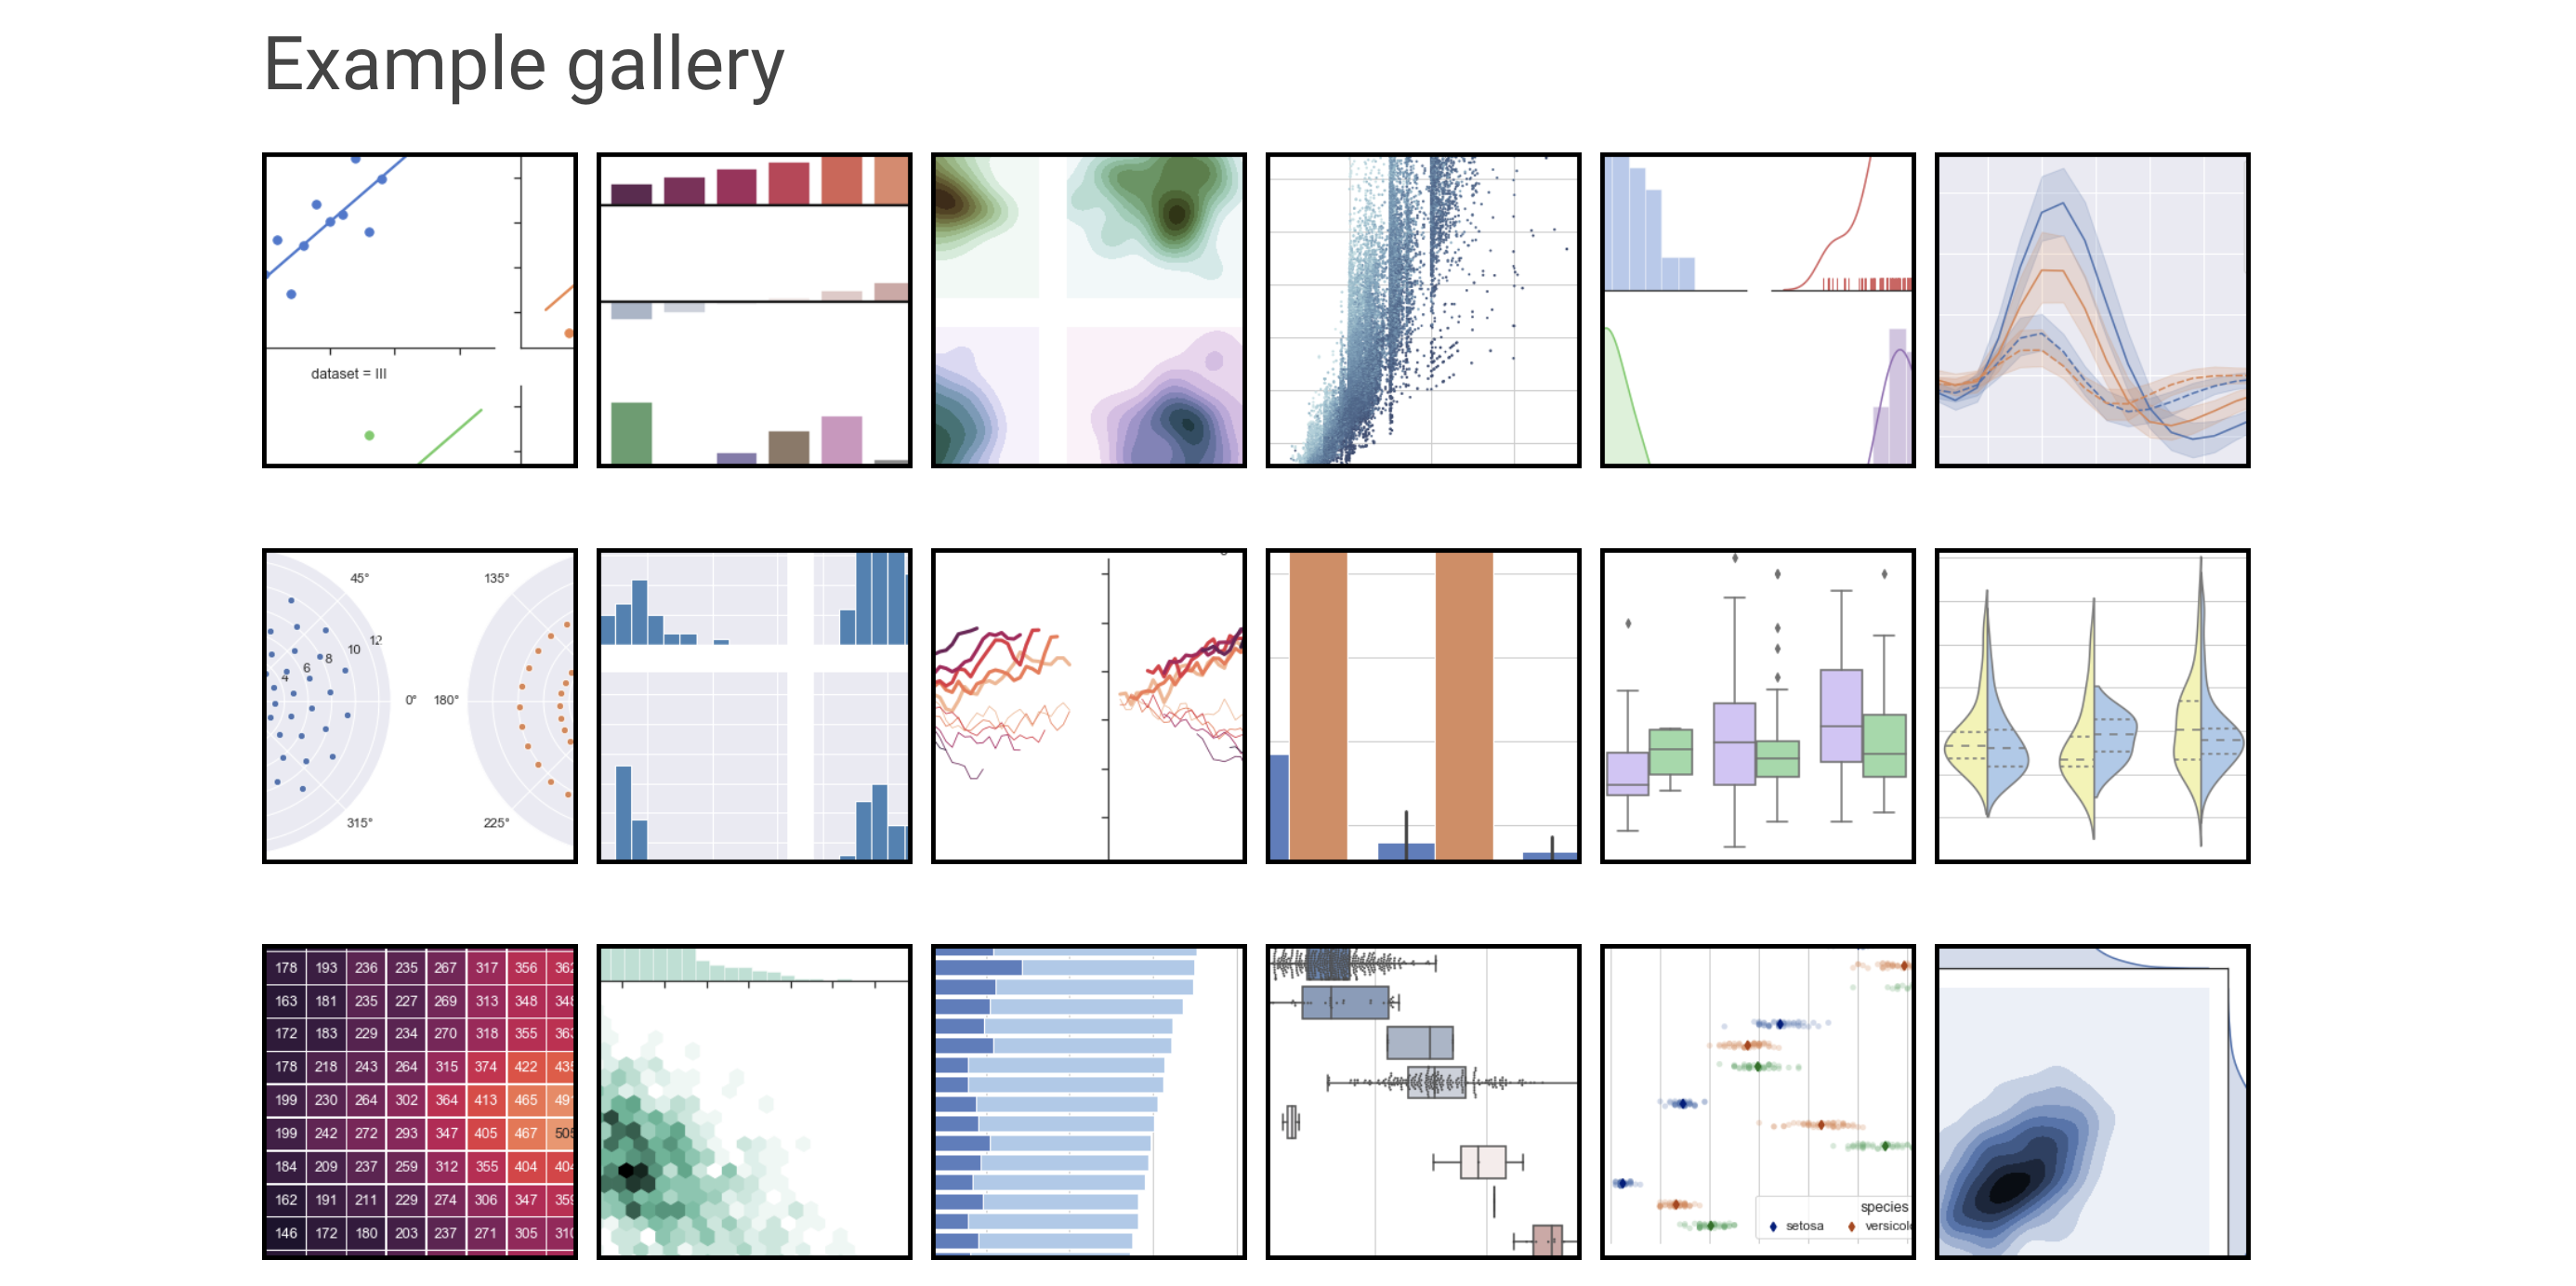

However, there was still a problem: all of these libraries offer __static plots__.
These plots can only tell you what they show on screen.
You aren’t able to dive deeper into the plots, hover over points to find out information or add filters.

Plots that are able to perform functions like these are named __Interactive Visualizations__.

Interactive Visualizations are popular for adding a ton of information on top of the plots you’re presenting, unlocking possibilities and making you look 10x cooler. 

The library that made this possible is called __Plotly__.
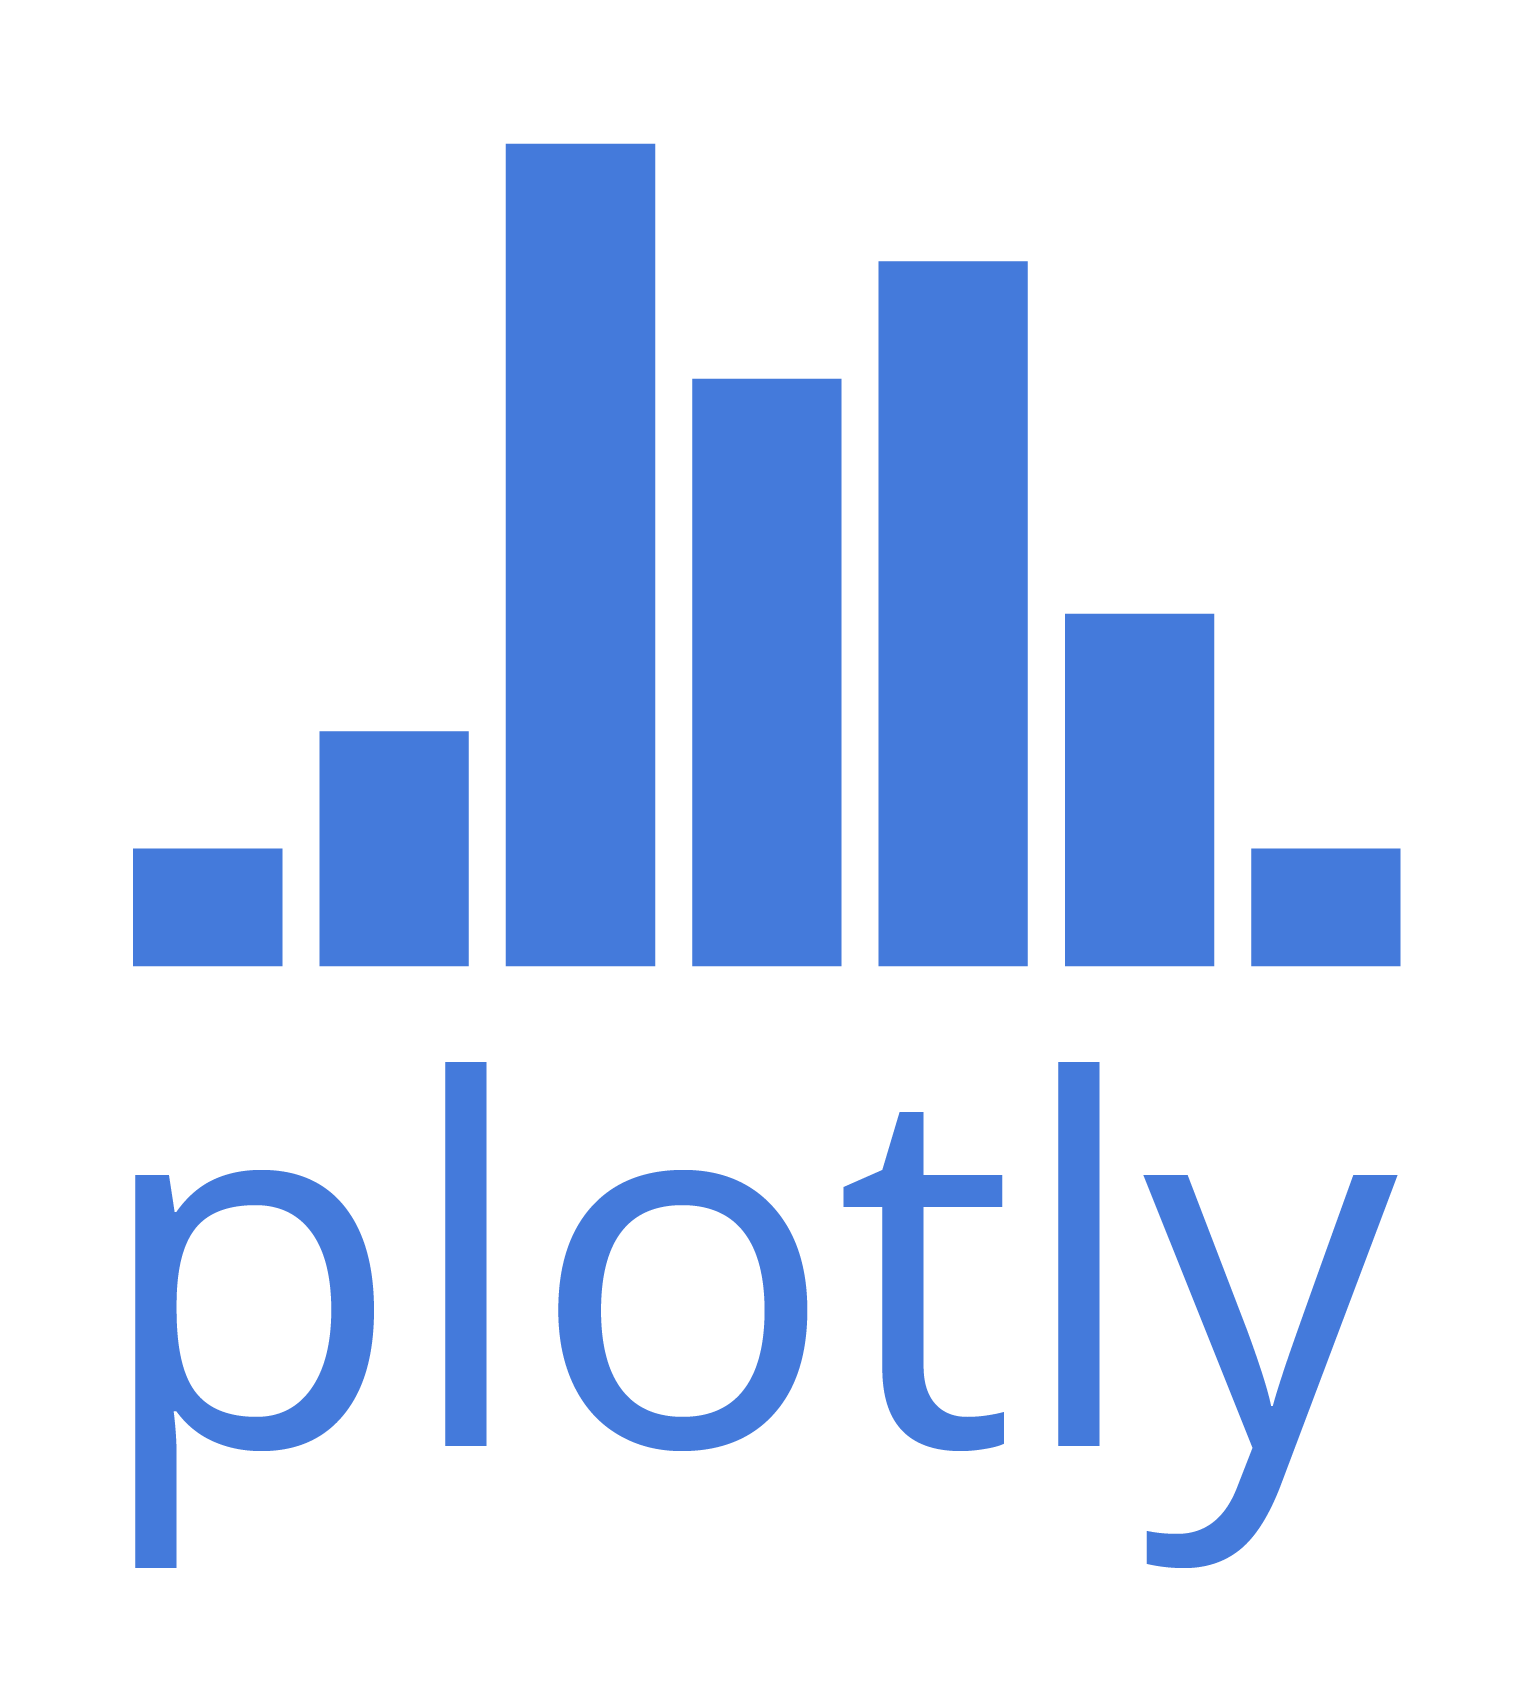

## What kind of Graphs does Plotly Plot?

- All __Matplotlib__ and __Seaborn Charts__
- __Statistical Charts__ which includes but not limited to Parallel Categories and Probability Tree Plots
- __Scientific Charts__ you never thought of, ranging from Network Graphs to Radar Charts
- __Financial Charts__ which are useful for Time-Series Analysis, examples include Candlesticks, Funnels and Bullet Charts
- __Geological Maps__ and 3 Dimensional Plots which allows you to interact with them

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread("plotly.gif")
plt.imshow(img)

An advanced example in parameter optimisation of RL alghoritm.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread("plotlyExample.gif")
plt.imshow(img)

## Why is Plotly so Popular?

- Interactive Plots
- Prettier than Matplotlib/Seaborn (Up for debate ?)
- Offers a more detailed visualization which assists in exploring, understanding and communicating your data
- Provides maximum customization for your plots including
adding sliders and filters
- Much cleaner and understandable code base
- Backed up by a company named Plotly, which makes interactive web-based visualizations and web-applications